# Introducción a la Ciencia de Datos: Tarea 2

Este notebook contiene el código de base para realizar la Tarea 2 del curso. Puede copiarlo en su propio repositorio y trabajar sobre el mismo.
Las **instrucciones para ejecutar el notebook** están en la [página inicial del repositorio](https://gitlab.fing.edu.uy/maestria-cdaa/intro-cd/).

**Se espera que no sea necesario revisar el código para corregir la tarea**, ya que todos los resultados y análisis relevantes deberían estar en el **informe en formato PDF**.


## Cargar bibliotecas (dependencias)
Recuerde instalar los requerimientos (`requirements.txt`) en el mismo entorno donde está ejecutando este notebook (ver [README](https://gitlab.fing.edu.uy/maestria-cdaa/intro-cd/)). Para la entrega 2 hay nuevas dependencias, por lo que es importante correr la siguiente celda.

In [3]:
!pip3 install -r requirements.txt

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.


In [4]:
import re
import os

from time import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.corpus import wordnet
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')  # Necesario para tokenizar
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')   # Para sinónimos y definiciones
nltk.download('averaged_perceptron_tagger_eng')  # Para etiquetas gramaticales

import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

!pip install wordcloud
from wordcloud import WordCloud

zsh:1: command not found: pip


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading punkt_tab: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading omw-1.4: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading averaged_perceptron_tagger_eng: <urlopen
[nltk_data]     error [SSL: CERTIFICATE_VERIFY_FAILED] certificate
[nltk_data]     verify failed: unable to get local issuer certificate
[nltk_data] 

## Lectura de Datos

In [5]:
# DataFrame con todos los discursos:
pd.set_option('display.max_rows', None)
df_speeches = pd.read_csv('C:/Users/lulag/introCD/data/us_2020_election_speeches.csv')
df_speeches

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/lulag/introCD/data/us_2020_election_speeches.csv'

In [ ]:
# Separación de speakers múltiples
df_speeches['speaker'] = df_speeches['speaker'].str.split(',')
df_speeches = df_speeches.explode('speaker')
df_speeches['speaker'] = df_speeches['speaker'].str.strip()

In [ ]:
# Selección de los 3 candidatos con más discursos
presidents = ["Joe Biden", "Donald Trump", "Mike Pence"]

# df_speeches_top_3 = ...
def presencia(df, column, names):
    return df[column].astype(str).apply(lambda x: 1 if any(name in x for name in names) else 0)
boolean = presencia(df_speeches, 'speaker', presidents)    
df_speeches_top_3 = df_speeches[boolean == 1]
# Eliminación de Donald Trump Jr. (hijo)
df_speeches_top_3 = df_speeches_top_3.drop(136)

# Reseteo del índice
df_speeches_top_3.reset_index(drop=True, inplace=True)
df_speeches_top_3

## Limpieza de Textos

In [ ]:
# 1 - Función clean_text() de la entrega anterior

def clean_text(df, column_name):
    # Eliminar primeras palabras hasta el primer "\n"
    result = df[column_name].str.replace(r"^[^\n]*\n", "", regex=True)
    # Convertir todo a minúsculas
    result = result.str.lower()
    # Completar signos de puntuación faltantes
    for punc in ["\n", "[", "]", ",", ":", ".", ";", "!", "”", "“", "-", "/", "(", ")", "?","…","’","‘"]:
        result = result.str.replace(punc, " ")
    return result

# Creación de una nueva columna CleanText a partir de text
df_speeches_top_3["CleanText"] = clean_text(df_speeches_top_3,'text')
# df_speeches_top_3["CleanText"]

In [6]:
# 2 - Eliminación de stopwords

# Lista de stopwords
stop_words = set(stopwords.words('english'))
# print(stop_words)

# Función para eliminar stopwords de un texto
def remove_stopwords(text):
    tokens = word_tokenize(text)  # Divide el texto en palabras
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

df_speeches_top_3["CleanText"] = df_speeches_top_3["CleanText"].apply(remove_stopwords)
# df_speeches_top_3["CleanText"]

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/isabellabuschiazzo/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.10/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.10/share/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.10/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [7]:
# 3 - Separación de contracciones y escritura de forma completa

# La lista de stopwords que se eliminaron en la celda anterior incluye varias contracciones.
# En este paso se expande la contracciones que puedan no haber sido consideradas por la lista de stopwords de nltk.
contraction_list = {
    "let's": "let us",
    "what's": "what is",
    "it's": "it is",
    "you'll": "you will",
    "i'll": "i will",
    "i'm": "i am",
    "he'll": "he will",
    "she'll": "she will",
    "they'll": "they will",
    "we'll": "we will",
    "can't": "cannot",
    "won't": "will not",
    "doesn't": "does not",
    "don't": "do not",
    "isn't": "is not",
    "aren't": "are not",
    "hasn't": "has not",
    "haven't": "have not",
    "hadn't": "had not",
    "i've": "i have",
    "you've": "you have",
    "you're": "you are",
    "we've": "we have",
    "we're": "we are",
    "they're": "they are",
    "they've": "they have",
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "that's": "that is",
    "there's": "there is",
    "here's": "here is",
    "wasn't": "was not",
    "weren't": "were not",
    "didn't": "did not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "couldn't": "could not",
    "mustn't": "must not",
    "mightn't": "might not",
    "needn't": "need not",
    "i'd": "i would",
    "you'd": "you would",
    "he'd": "he would",
    "she'd": "she would",
    "we'd": "we would",
    "they'd": "they would",
    "it'd": "it would",
    "who's": "who is",
    "who've": "who have",
    "who'd": "who would",
    "how's": "how is",
    "when's": "when is",
    "why's": "why is",
    "ain't": "is not",
}
# Sustitución del apóstrofe gráfico
df_speeches_top_3["CleanText"] = df_speeches_top_3["CleanText"].apply(lambda x: x.replace("’", "'") if isinstance(x, str) else x)
def expand_contractions(text, contractions=contraction_list):
    pattern = re.compile(r'\b(' + '|'.join(re.escape(k) for k in contractions.keys()) + r')\b')
    return pattern.sub(lambda x: contractions[x.group()], text)

df_speeches_top_3["CleanText"] = df_speeches_top_3["CleanText"].apply(expand_contractions)

NameError: name 'df_speeches_top_3' is not defined

In [8]:
# 4 - Eliminación de números

def remove_numbers(text):
    # Elimina números, 
    # incluyendo sufijos como: 'th', 'st', 'nd', 'rd', 's'.
    return re.sub(r'\b\d+(?:\.\d+)?(?:st|nd|rd|th|s|k|ks|census)?\b', '', text)

df_speeches_top_3["CleanText"] = df_speeches_top_3["CleanText"].apply(remove_numbers)

NameError: name 'df_speeches_top_3' is not defined

In [9]:
# 5 - Lematización

# Inicialización del lematizador
lemmatizer = WordNetLemmatizer()

# Función para mapear etiquetas POS de nltk a las que requiere WordNet
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default

# Función de lematización
def lemmatize_text(text):
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return ' '.join(lemmatized)

df_speeches_top_3["CleanText"] = df_speeches_top_3["CleanText"].apply(lemmatize_text)
# df_speeches_top_3["CleanText"]

NameError: name 'df_speeches_top_3' is not defined

## Parte 1: Dataset y representación numérica de texto

In [10]:
# 1: Separar del 30% del conjunto para test. Al 70 % restante para entrenamiento se lo llama "dev" (desarrollo).

# Definición de variables
X = df_speeches_top_3["CleanText"]      # Características: transcripciones de discursos (columna 'CleanText' del DataFrame)
y = df_speeches_top_3["speaker"]        # Etiqueta: presidente que pronunció el discurso (columna 'speaker' del DataFrame)

# División estratificada
X_dev, X_test, y_dev, y_test = train_test_split(
    X, y,
    test_size = 0.3,            # 30% se separa para test
    stratify = y,               # Respeta las proporciones entre candidatos
    random_state = 17           # Para reproducibilidad
)

print(f"Tamaños de los conjuntos: \nEntrenamiento:{X_dev.shape} Testeo:{X_test.shape}")

NameError: name 'df_speeches_top_3' is not defined

In [11]:
# 2: Visualización de la proporción de cada candidato por conjunto

# Creación de un DataFrame con las proporciones
train_dist = y_dev.value_counts(normalize=True).rename("Entrenamiento")
test_dist = y_test.value_counts(normalize=True).rename("Evaluación")
balance_df = pd.concat([train_dist, test_dist], axis=1)

# Gráfico de barras
balance_df.plot(kind='bar')
plt.title("Proporción de discursos por candidato \nen los conjuntos de entrenamiento y evaluación")
plt.xlabel("Candidato")
plt.ylabel("Proporción")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(title='Conjunto:')
plt.show()

NameError: name 'y_dev' is not defined

In [12]:
# 3: Transforme el texto del conjunto de entrenamiento a la representación numérica (features) de conteo de palabras o bag of words.

# Creación del vectorizador
vectorizer = CountVectorizer()

# Entrenamiento y transformación de los textos
X_dev_bow = vectorizer.fit_transform(X_dev)

# Mostrar la forma de la matriz
print("Dimensiones de la matriz BoW:", X_dev_bow.shape)
# Ejemplo: algunas palabras del vocabulario
print("Algunas palabras del vocabulario:", vectorizer.get_feature_names_out()[1020:1030])

NameError: name 'X_dev' is not defined

In [13]:
# Cantidad total de celdas en la matriz
total_cells = X_dev_bow.shape[0] * X_dev_bow.shape[1]

# Cantidad de celdas distintas de cero
cells_non_zero = X_dev_bow.count_nonzero()

# Porcentaje de celdas distintas de cero
perc_non_zero = (cells_non_zero / total_cells) * 100

print(f"Cantidad de celdas distintas de cero: {cells_non_zero:.0f}")
print(f"Porcentaje de celdas distintas de cero: {perc_non_zero:.4f}%")

NameError: name 'X_dev_bow' is not defined

In [14]:
# 4: Obtenga la representación numérica Term Frequency - Inverse Document Frequency.

# Inicialización del transformador
tfidf_transformer = TfidfTransformer()
# Ajuste y transformación de la matriz de conteo
X_dev_tfidf = tfidf_transformer.fit_transform(X_dev_bow)

# Mostrar la forma de la matriz
print("Dimensiones de la matriz TfIdf:", X_dev_tfidf.shape)

NameError: name 'X_dev_bow' is not defined

In [15]:
# Visualización de TF-IDF > 0 para un discurso de ejemplo

# Para el primer speech: Joe Biden
text_index = 0

# Vector TF-IDF en formato denso
text_vector = X_dev_tfidf[text_index].toarray()[0]

# Nombres de las palabras
feature_names = vectorizer.get_feature_names_out()

# Filtro de términos con TF-IDF > 0
non_zero_terms = [(feature_names[i], text_vector[i]) 
                  for i in range(len(text_vector)) if text_vector[i] > 0]

# Visualización de términos con su peso (ordenados por importancia)
non_zero_terms_sorted = sorted(non_zero_terms, key=lambda x: x[1], reverse=True)
# Primeros 10
print(non_zero_terms_sorted[:10])

NameError: name 'X_dev_tfidf' is not defined

In [16]:
# Visualización de lo anterior como Wordmap

# Creación del diccionario: {palabra: peso TF-IDF}
word_weights = {
    feature_names[i]: text_vector[i]
    for i in range(len(text_vector)) if text_vector[i] > 0
}

# Generación de la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(word_weights)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Nube de palabras - Discurso #{text_index} {df_speeches_top_3.iloc[text_index]["speaker"]}')
plt.show()

NameError: name 'text_vector' is not defined

In [17]:
# 5 :Muestre en un mapa el conjunto de entrenamiento, utilizando las dos primeras componentes PCA sobre los vectores de tf-idf.

# Aplicación de PCA 
components = 2
pca = PCA(n_components = components)
X_pca = pca.fit_transform(X_dev_tfidf.toarray())

# Obtenención de etiquetas
labels = y_dev.values

# Scatter Plot
plt.figure(figsize=(10, 6))
for speaker in set(labels):
    idx = labels == speaker
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=speaker, alpha=0.7)

plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Proyección PCA de los discursos (TF-IDF)")
plt.legend(title="Candidato:")
plt.grid(True)
plt.show()

NameError: name 'X_dev_tfidf' is not defined

In [477]:
# ¿Qué palabras contribuyen más al Componente Principal 1?

# Obtenención de las componentes (matriz: n_componentes x n_palabras)
components = pca.components_

# Obtenención de nombres de las palabras del vectorizador
feature_names = vectorizer.get_feature_names_out()

# Para la primera componente
comp_idx = 0  
top_indices = np.argsort(components[comp_idx])[::-1]  # Mayor contribución primero

# Mostrar las 10 palabras que más contribuyen a la primera componente
top_words = [(feature_names[i], components[comp_idx][i]) for i in top_indices[:10]]
print("Palabras que más contribuyen a la componente principal 1:")
for word, weight in top_words:
    print(f"{word}: {weight:.4f}")

Palabras que más contribuyen a la componente principal 1:
donald: 0.3857
trump: 0.3579
say: 0.2323
great: 0.2185
go: 0.1862
want: 0.1369
right: 0.1169
year: 0.1085
know: 0.1069
china: 0.0893


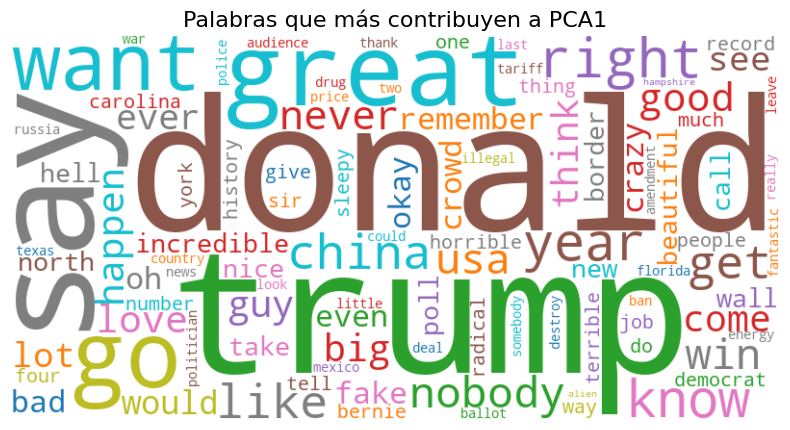

In [478]:
# Selección de palabras que más contribuyen al Componente Principal 1
top_words = [(feature_names[i], components[comp_idx][i]) for i in top_indices[:100]]  # Se toma 100 para mejor visualización

# Creación de diccionario con pesos
word_weights = {word: abs(weight) for word, weight in top_words}  # abs para que no haya pesos negativos

# Generación de nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='tab10').generate_from_frequencies(word_weights)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Palabras que más contribuyen a PCA1", fontsize=16)
plt.show()

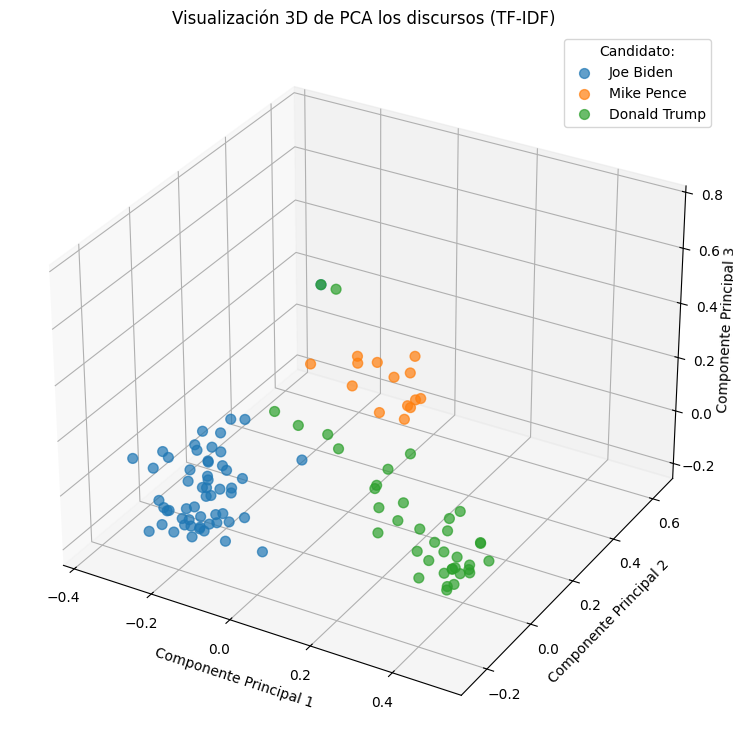

In [479]:
# Selección de 3 Componentes Principales

# PCA con 3 componentes
components = 3
pca_3d = PCA(n_components = components)
X_pca_3d = pca_3d.fit_transform(X_dev_tfidf.toarray())  # Pasa el array a denso si es sparse

# Figura 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for speaker in set(y_dev):
    idx = y_dev == speaker
    ax.scatter(X_pca_3d[idx, 0], X_pca_3d[idx, 1], X_pca_3d[idx, 2], label=speaker, s=50, alpha=0.7)

ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3", labelpad=0)
ax.set_title("Visualización 3D de PCA los discursos (TF-IDF)")
ax.legend(title="Candidato:")
plt.tight_layout(pad=2.5)
plt.show()

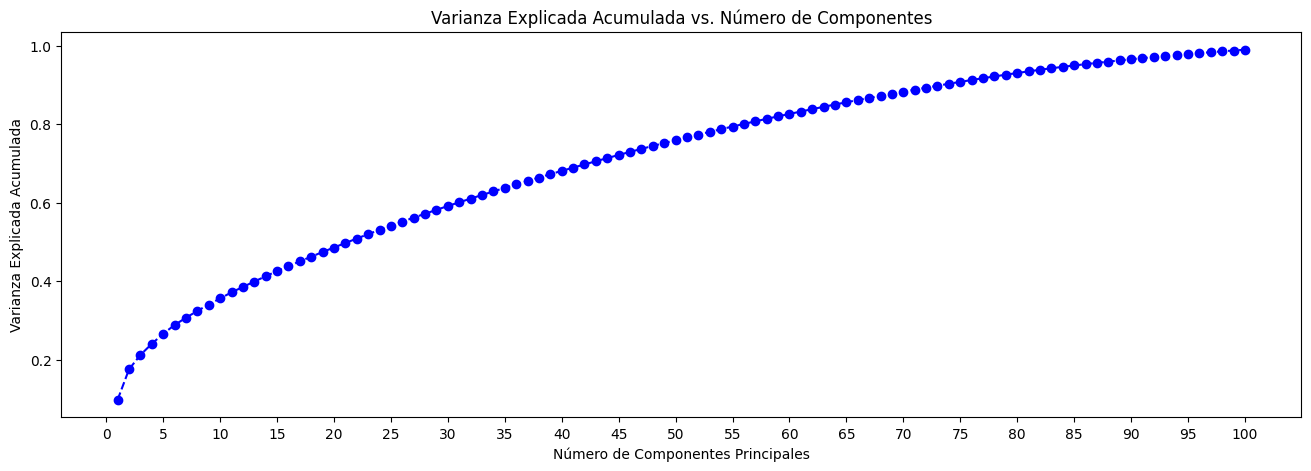

In [517]:
# Haga una visualización que permita entender cómo varía la varianza explicada a medida que se agregan componentes (e.g: hasta 10 componentes).

# PCA sobre la matriz TF-IDF
components = 100
pca = PCA(n_components = components)
X_pca = pca.fit_transform(X_dev_tfidf.toarray())

# Varianza explicada individual
varianza_explicada = pca.explained_variance_ratio_
# Varianza explicada acumulada
varianza_acumulada = np.cumsum(varianza_explicada)
# print(varianza_acumulada)

# Gráfico
plt.figure(figsize=(16, 5))
plt.plot(range(1, components+1), varianza_acumulada, marker='o', linestyle='--', color='b')
plt.xticks(np.arange(0, components+1, 5))
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada vs. Número de Componentes')
plt.show()

## Parte 2: Entrenamiento y Evaluación de Modelos


In [481]:
# 1: Entrene el modelo Multinomial Naive Bayes, luego utilícelo para predecir sobre el conjunto de test, y reporte el valor de accuracy y la matriz de confusión. Reporte el valor de precision y recall para cada candidato. 
# Calcular matriz de confusión. Sugerencia: utilice el método from_predictions de ConfusionMatrixDisplay para realizar la matriz.

# Transformación de textos de test al espacio de BoW usando el vectorizer entrenado
X_test_bow = vectorizer.transform(X_test)

# Transformación de matriz BoW al espacio TF-IDF usando el transformer entrenado
X_test_tfidf = tfidf_transformer.transform(X_test_bow) 

# Mostrar la forma de la matriz
print("Dimensiones de la matriz TfIdf:", X_test_tfidf.shape)

Dimensiones de la matriz TfIdf: (47, 10877)


In [482]:
# Entrenamiento del modelo con el conjunto de desarrollo
nb_model = MultinomialNB()
nb_model.fit(X_dev_tfidf, y_dev)  # y_dev vector con las etiquetas (candidatos)

# Predicción de las etiquetas del conjunto de test
y_pred = nb_model.predict(X_test_tfidf)

# Cálculo de accuracy (porcentaje de aciertos)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8298


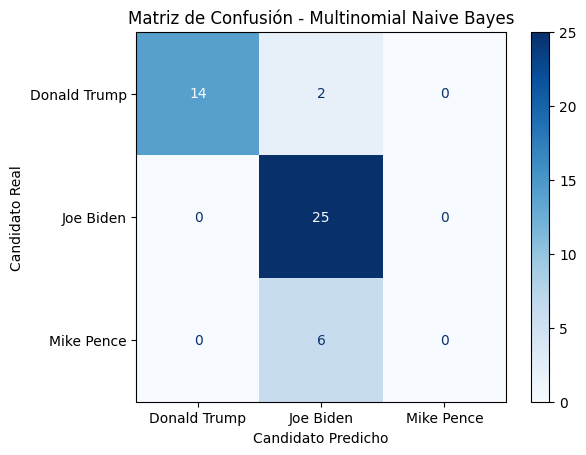

In [483]:
# Matriz de Confusión 

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")

plt.title("Matriz de Confusión - Multinomial Naive Bayes")
plt.xlabel("Candidato Predicho")
plt.ylabel("Candidato Real")
plt.show()

In [484]:
# Revisión de las clases reales y predichas
print("Clases verdaderas en test:", np.unique(y_test))
print("Clases predichas por el modelo:", np.unique(y_pred))

# Para ver la frecuencia de cada clase
print("\nFrecuencia de clases verdaderas:")
print(pd.Series(y_test).value_counts())

print("\nFrecuencia de clases predichas:")
print(pd.Series(y_pred).value_counts())

Clases verdaderas en test: ['Donald Trump' 'Joe Biden' 'Mike Pence']
Clases predichas por el modelo: ['Donald Trump' 'Joe Biden']

Frecuencia de clases verdaderas:
speaker
Joe Biden       25
Donald Trump    16
Mike Pence       6
Name: count, dtype: int64

Frecuencia de clases predichas:
Joe Biden       33
Donald Trump    14
Name: count, dtype: int64


In [485]:
# Precisión y Recall para cada Candidato

print("Reporte de métricas por candidato:")
print(classification_report(y_test, y_pred, zero_division=0)) # "Mike Pence" no es un valor predicho por el modelo

Reporte de métricas por candidato:
              precision    recall  f1-score   support

Donald Trump       1.00      0.88      0.93        16
   Joe Biden       0.76      1.00      0.86        25
  Mike Pence       0.00      0.00      0.00         6

    accuracy                           0.83        47
   macro avg       0.59      0.62      0.60        47
weighted avg       0.74      0.83      0.78        47



In [486]:
# Hiperparámetros por defecto del modelo

# Diccionario con todos los parámetros posibles
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])
params = pipeline.get_params()

# Visualización como tabla
params_df = pd.DataFrame(params.items(), columns=["Hiperparámetro", "Valor por defecto"])
params_df

,Hiperparámetro,Valor por defecto
0,memory,None
1,steps,"[(tfidf, TfidfVectorizer()), (clf, Multinomial..."
2,transform_input,None
3,verbose,False
4,tfidf,TfidfVectorizer()
5,clf,MultinomialNB()
6,tfidf__analyzer,word
7,tfidf__binary,False
8,tfidf__decode_error,strict
9,tfidf__dtype,<class 'numpy.float64'>


In [535]:
# 2: Implemente una búsqueda de hiperparámetros usando GridSearchCV.

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,1),min_df=5,max_df=0.9)),   # Paso 1: convierte el texto en vectores TF-IDF.
    ('clf', MultinomialNB())        # Paso 2: entrena un clasificador Naive Bayes con esos vectores.
])

# Definición de hiperparámetros a explorar
param_grid = {
    #'tfidf__ngram_range': [(1, 1), (1, 2)],   # Define si se usan solo unigramas o también bigramas.
    #'tfidf__min_df': [1, 3, 5],               # Ignora palabras que aparecen en menos de n documentos.
    #'tfidf__max_df': [0.9, 1.0],              # Ignora palabras que aparecen en más de n documentos.
    'clf__alpha': [0.01, 0.1, 1.0],            # Hiperparámetro de suavizado de Laplace en Naive Bayes (ayuda a evitar ceros en probabilidades).
    'clf__fit_prior': [True, False]            # Si se deben aprender las probabilidades previas de las clases
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,                        # Validación cruzada con 5 particiones.
    scoring='accuracy',          # Métrica para comparar modelos: accuracy.
    return_train_score=True,
    n_jobs=-1
)

grid.fit(X_dev, y_dev)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.9, min_df=5)),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.01, 0.1, 1.0],
                         'clf__fit_prior': [True, False]},
             return_train_score=True, scoring='accuracy')

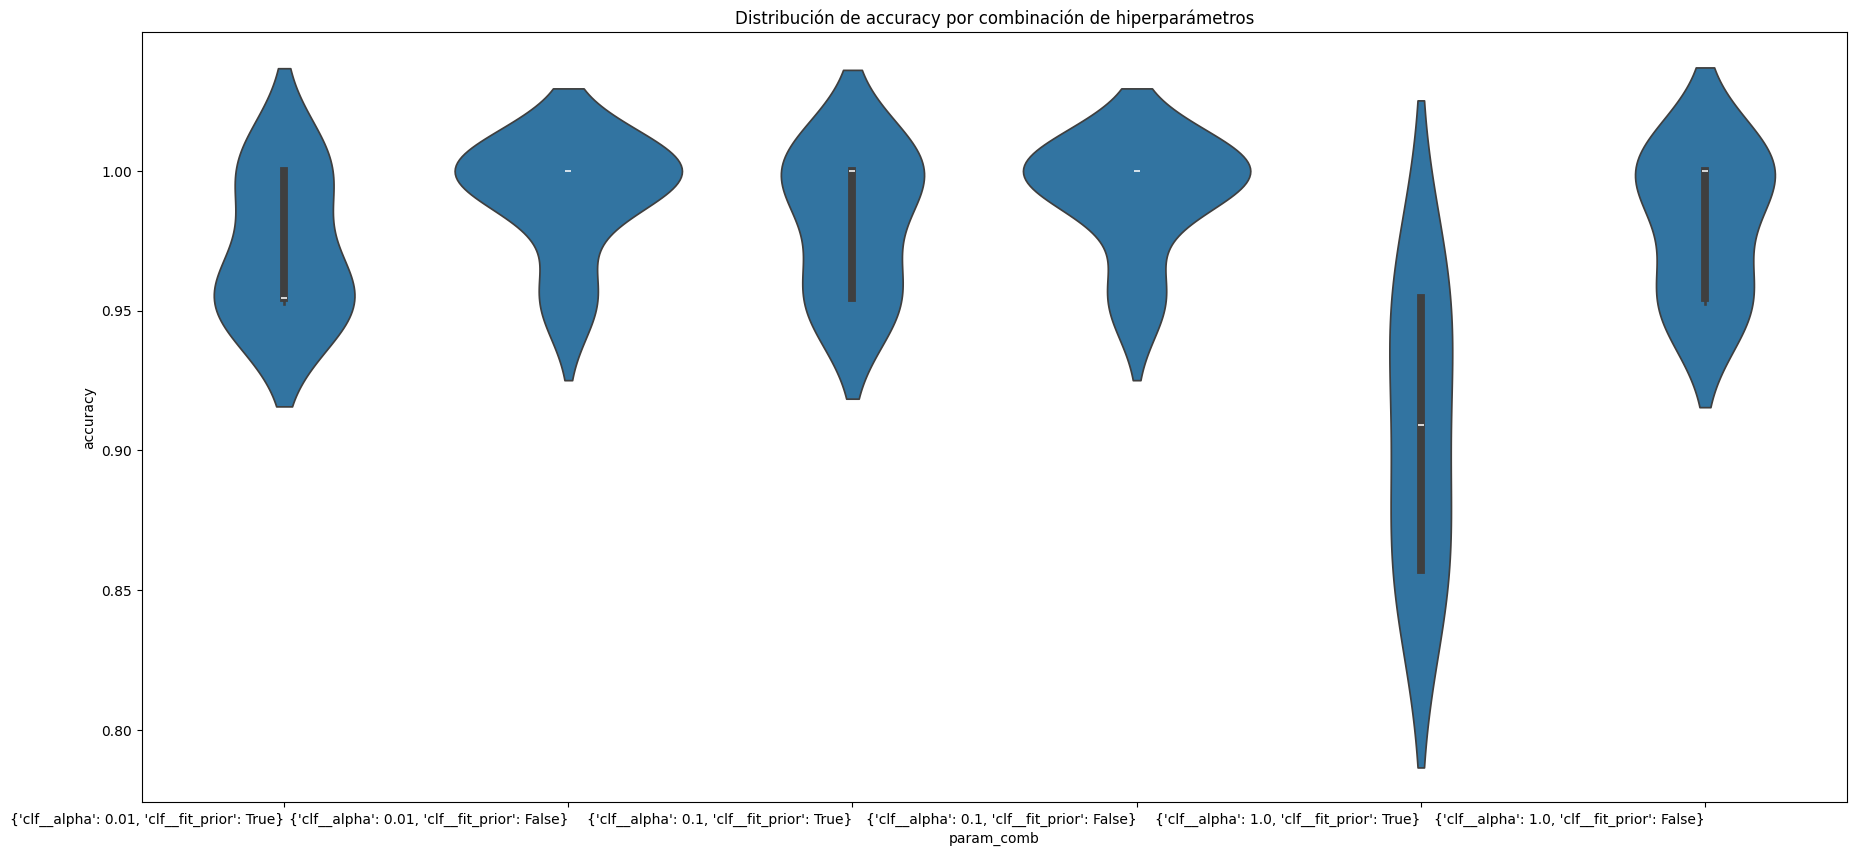

In [552]:
# Genere una visualización que permita comparar las métricas (e.g: accuracy) de los distintos modelos entrenados, viendo el valor promedio y variabilidad de las mismas en todos los splits (e.g: en un gráfico de violín).

# Conversión de los resultados en un DataFrame
results = pd.DataFrame(grid.cv_results_)

# Creación de una columna identificadora de cada combinación de hiperparámetros
results['param_comb'] = results['params'].apply(lambda d: str(d))

# Creación de un DataFrame "long" para seaborn
split_scores = []

for i in range(grid.cv):
    split_scores.extend([
        {
            'param_comb': results.loc[j, 'param_comb'],
            'split': i,
            'accuracy': results.loc[j, f'split{i}_test_score']
        }
        for j in range(len(results))
    ])

split_scores_df = pd.DataFrame(split_scores)

# Gráfico de violín
plt.figure(figsize=(22, 10))
sns.violinplot(
    data=split_scores_df,
    x='param_comb',
    y='accuracy'
)
plt.xticks(ha='right')
plt.title("Distribución de accuracy por combinación de hiperparámetros")
plt.show()

In [537]:
# 3: Elija el mejor modelo (mejores parámetros) y vuelva a entrenar sobre todo el conjunto de entrenamiento disponible (sin quitar datos para validación). Reporte el valor final de las métricas y la matriz de confusión.

# Mejores hiperparámetros encontrados 
print("Mejores hiperparámetros encontrados:")
print(grid.best_params_)
print("Accuracy Promedio:")
print(grid.best_score_)

# Mejor modelo entrenado
best_model = grid.best_estimator_

Mejores hiperparámetros encontrados:
{'clf__alpha': 0.01, 'clf__fit_prior': False}
Accuracy Promedio:
0.990909090909091


Reporte de clasificación:

              precision    recall  f1-score   support

Donald Trump       1.00      1.00      1.00        16
   Joe Biden       1.00      1.00      1.00        25
  Mike Pence       1.00      1.00      1.00         6

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47



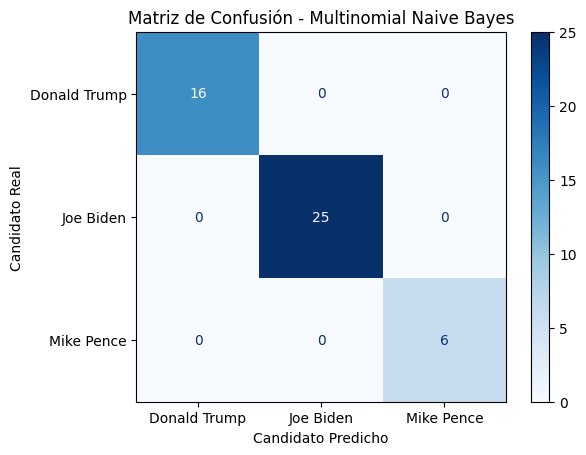

In [545]:
# Reentrenamiento del modelo sobre tODO el conjunto de desarrollo
best_model.fit(X_dev, y_dev)

# Predicción de etiquetas para el conjunto de testeo
y_test_pred = best_model.predict(X_test)

# Reporte de métricas finales
print("Reporte de clasificación:\n")
print(classification_report(y_test, y_test_pred))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, cmap="Blues")
plt.title("Matriz de Confusión - Multinomial Naive Bayes")
plt.xlabel("Candidato Predicho")
plt.ylabel("Candidato Real")
plt.show()